### Introduction

**The objective of this project is to demonstrate my A/B testing abilities with a public dataset. For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.**

### I - Import Dependencies

In [1]:
import pandas as pd

import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
import math

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   

### II - Import Data

In [2]:
df = pd.read_csv('ab_test.csv')
df.head(3)

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0


### III - Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**We have no null values within our dataframe. If we have null variables within the dataset we would have three options.**

1. Replace the null values with the average value
2. Replace with a value of 0
3. Drop all records that contains null values

#### Number of Unique Drivers

In [4]:
users = df.id.nunique()
print(f'We have {users} distinct users within the database')

We have 290584 distinct users within the database


#### Mismatched Drivers

In [5]:
df.groupby(['con_treat', 'page']).id.nunique()

con_treat  page    
control    new_page      1928
           old_page    145274
treatment  new_page    145310
           old_page      1965
Name: id, dtype: int64

We might have some mismatched users that appear in the treatment but entered the old page and some users that appear in the control that entered the new page. Since there is no way to know which record is correct, we should only accept users in the control group that used the old page and users in the control group that used the new page.

In [6]:
matched = df[(df.con_treat == 'treatment') & (df.page == 'new_page') | (df.con_treat == 'control') & (df.page == 'old_page')]
print(f'There are {matched.shape[0]} correctly matched users within our database')

There are 290585 correctly matched users within our database


#### Duplicate Rows

In [7]:
n_duplicates = matched[matched.duplicated()]
print(f'We seem to have {len(n_duplicates)} duplicate records in our database')

We seem to have 0 duplicate records in our database


We might have no duplicate records withing the dataframe but we might have duplicated users within the dataframe

In [8]:
matched[matched.duplicated("id") == True]

,id,time,con_treat,page,converted
2893,773192,55:59.6,treatment,new_page,0


In [9]:
matched[matched.id == 773192]

,id,time,con_treat,page,converted
1899,773192,37:58.8,treatment,new_page,0
2893,773192,55:59.6,treatment,new_page,0


*This user has been duplicated within the database and should be removed. The user has two records under different times that made our previous pre-processing method believe that it was a two different records.*

In [10]:
# Remove duplicated user
matched = matched.drop_duplicates("id", keep='first') #keeping the first entry

In [11]:
clean_df = matched.copy()

### IV - EDA

In [12]:
clean_df.id = clean_df.id.astype(str)
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
converted,290584.0,0.119597,0.32449,0.0,0.0,0.0,0.0,1.0


In [13]:
control = clean_df.loc[clean_df.con_treat == 'control']
treat = clean_df.loc[clean_df.con_treat == 'treatment']

print(f'The number of users in the control group is equal to:', round(len(control)/len(clean_df) *100, 2))
print(f'The number of users in the treatment group is equal to:', round(len(treat)/len(clean_df) *100, 2))

The number of users in the control group is equal to: 49.99
The number of users in the treatment group is equal to: 50.01


In [14]:
control_converted = control.query('converted == 1')
treat_converted = treat.query('converted == 1')
print('The sample sizes of the control group and treatment group are {} and {} respectively'.format(control.shape[0], treat.shape[0]))
print('The number of conversions in the exposed group and control group is {} and {} respectively'.format(control_converted.shape[0],
                                                                                          treat_converted.shape[0]))

The sample sizes of the control group and treatment group are 145274 and 145310 respectively
The number of conversions in the exposed group and control group is 17489 and 17264 respectively


In [15]:
#Given that the users treatment type, whats the probability that the user converted?
clean_df.groupby("page").mean() *100 

,converted
page,
new_page,11.880807
old_page,12.038630


The conversion rate of users within the control group was higher than those in the treatment group that used the new page. The probability suggests that there is no significant difference in convergence between treatment and control groups. 

Therefore, we could conclude that the new treatment page has no impact and does not lead to more conversions.

#### V - Hypothesis Testing

Here we will be formulating a null and an alternative hypothesis. The null hypothesis will state that there are no changes in conversion with the new page. The alternative hypothesis is what we wanted to confirm, i.e the conversion rate is higher with the new page compared to the old page.

                                        𝑁𝑢𝑙𝑙(𝐻0) 𝑎𝑛𝑑 𝐴𝑙𝑡𝑒𝑟𝑛𝑎𝑡𝑖𝑣𝑒(𝐻1) 𝐻𝑦𝑝𝑜𝑡ℎ𝑒𝑠𝑖𝑠:
 
                                                𝐻0: 𝑌𝑛𝑒𝑤− 𝑌𝑜𝑙𝑑=0
                                                𝐻1: 𝑌𝑛𝑒𝑤− 𝑌𝑜𝑙𝑑>0

In [16]:
#storing number of conversions for exposed and control groups as numpy arrays
count = np.array([treat_converted.shape[0], control_converted.shape[0]])

#storing sample sizes of exposed and control group as numpy arrays
nobs = np.array([treat.shape[0], control.shape[0]])
#storing results of z test in variables
stat, p_val = proportions_ztest(count, nobs, alternative = 'larger')
p_form = '{0:.2f}%'.format(p_val*100)
print('P-value is equal to {}'.format(p_form))

P-value is equal to 90.51%


In [17]:
# Draw 100000 samples from binominal distribution
treat_converted = np.random.binomial(treat.shape[0], treat.converted.mean(), 100000)/treat.shape[0]
control_simulation = np.random.binomial(control.shape[0], control.converted.mean(), 100000)/control.shape[0]
p_diffs = treat_converted - control_simulation
diffs = np.array(p_diffs)

#Creation of normal distribution centered at zero
null_vals = np.random.normal(0, np.std(diffs), len(diffs))

In [18]:
def statplot(data, lim, obs_stat, title):
    """
    This function creates a plot, that represents sampling distribution. 
    This plot is formatted and has main statistics on it
    Arguments:
    data = array
    lim = height of the plot
    obs_stat = observed statistic
    title = chart title
    """
    
    #Create a kdeplot
    plt.figure(figsize=(12,6))
    ax = sns.kdeplot(data, linewidth = 0.8, color = 'black')
    
    # Simple formatting
    frame = ['right', 'left', 'top']
    for i in frame:
        ax.spines[i].set_visible(False)

    plt.title(title)
    plt.ylabel('')
    plt.yticks([], [])
    
    # Legend
    line = Line2D([0], [0], color='red', linestyle = '-', label='observed statistic')
    line_dashed = Line2D([0], [0], color='black', linestyle = '--', label='mean and standard deviation')
    plt.legend(handles=[line, line_dashed], loc='upper left');
    
    # Create a list of 3 standard deviation to the left and to the right and mean
    std_list = []
    std_list_format = []
    for i in range(-3,4):
        std_dev = np.std(data) * i + np.mean(data)
        std_list.append(std_dev)
        std_list_format.append('{0:.3f}'.format(std_dev) + '\n {} std'.format(i))
        
    # Create a list of corresponding y values
    data_x, data_y = ax.lines[0].get_data()
    height = []
    for i in std_list:
        height.append(np.interp(i, data_x, data_y))
        
    # Plotting vertical lines representing std deviations 
    for a, b in zip(std_list, height):
        plt.axvline(a, 0, b/lim, color = 'black', alpha = 1, linewidth = 0.8, linestyle = '--')
        plt.plot(a, b, marker = 'o', color = 'blue')
    
    # Plotting observed statistic
    obs_line_height = np.interp(obs_stat, data_x, data_y)
    plt.axvline(obs_stat, 0, obs_line_height/lim, color = 'red', alpha = 1, linewidth = 0.8, linestyle = '-')
    plt.plot(obs_stat, obs_line_height, marker = 'o', color = 'red')
            
    # Plotting x ticks
    x_ticks = std_list
    x_labels = std_list_format
    plt.xticks(x_ticks, x_labels)
    plt.ylim(0,lim)

In [19]:
def shading(data, left, right, color):
    
    """
    This function shades areas of the kde plot.
    Arguments:
    data = array
    left = left boundary of the area to be shaded
    right = right boundary of the area to be shaded
    color = color
    """
    
    #Shading areas
    kde = stats.gaussian_kde(data)
    shade = np.linspace(left, right, 100)
    plt.fill_between(shade, kde(shade), color = color, alpha = 0.5);

Text(0.075, 1, 'P-value = 90.51%')

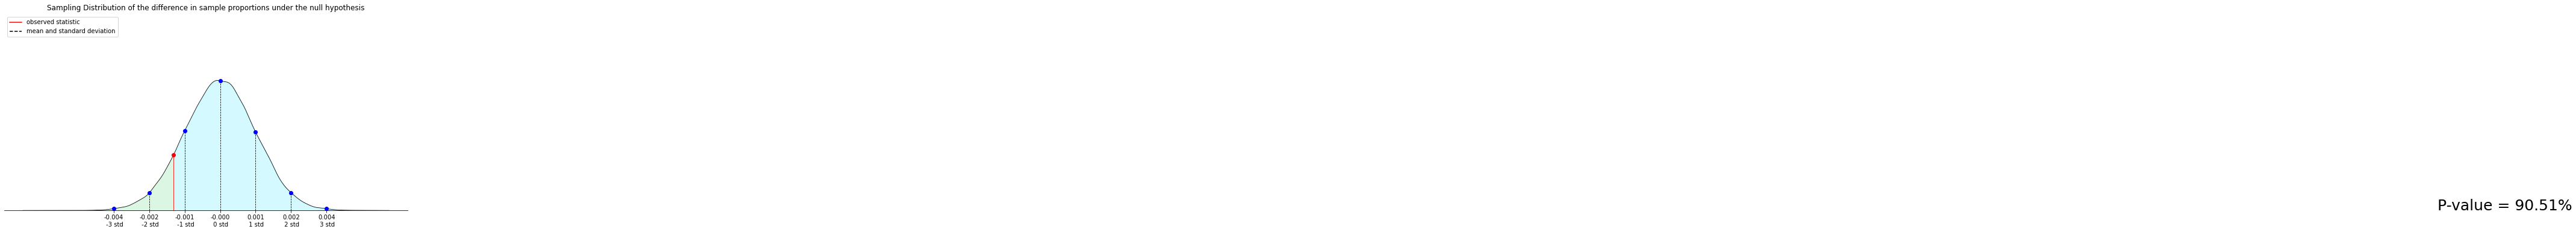

In [20]:
# Plotting the sampling distribution
obs_diff = treat.converted.mean() - control.converted.mean()
statplot(null_vals, 500, obs_diff, 'Sampling Distribution of the difference in sample proportions under the null hypothesis')
shading(null_vals, obs_diff, null_vals.max(),'#aaf4ff')
shading(null_vals, null_vals.min(), obs_diff,'#b9f0c8')
plt.text(0.075, 1, "P-value = {}".format(p_form), color = 'black', size = 25)

The plot above is the sampling distribution of the difference in sample proportions under the null hypothesis. The observed difference in conversion rates is less than the first standard deviation with a p-value of 90.51%. Given that our level of significance is 5%, we fail to reject the null hypothesis, i.e we do not have enough evidence to conclude that the conversion rate with the new page is higher than the old page. This emphasizes of initial conclusion that there is no significant impact for the new page.

#### VI - Conclusion

First, we investigated the relationships and structures in the data. There was no missing values but was one user that was duplicated. We also had issues with users under the wrong labels. Some users were categories under the treatment group but entered the old page. This needed to be resolved before conducting A/B testing.

After applying A/B Testing, the analysis gave us some important information. There was no statistical significance between the two groups meaning that we don’t have enough evidence to say that the new page is better than the old page. 

**Therefore, it’s my recommendation that the business continues to use the old page as the new page is neither practically nor statistically significant.**